In [48]:
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt

from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score

plt.style.use("ggplot")
plt.rcParams['figure.figsize'] = (12, 8)

## Lasso and Ridge

### Perform Lasso and Ridge regression on the wine dataset. Compare the value of coefficients obtained by these two methods with standard regression coefficients.

In [107]:
def cross_validate_regression(model_cls, X, y, n_folds, **kwargs):
    if 'alpha' in kwargs:
        alpha = kwargs['alpha']
    
    kf = KFold(n_folds, shuffle=True, random_state=101)
    MSEs = [0 for _ in range(n_folds)]
    r2s = [0 for _ in range(n_folds)]
    coefs = [0 for _ in X.columns]
    ix = 0
    
    return_model = None
    return_score = None
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]

        model = model_cls(0.01, **kwargs)
        model.fit(X_train, y_train)

        preds = model.predict(X_test)
        MSEs[ix] = mean_squared_error(y_test, preds)
        r2s[ix] = r2_score(y_test, preds)
        model_score = model.score(X_train, y_train)

        coefs = [coefs[i] + c for i, c in enumerate(model.coef_)]

        if return_model is None:
            return_model = model
            return_score = model.score(X_train, y_train)
        elif return_score < model_score:
            return_model = model
            return_score = model_score
        ix += 1
        
    return (MSEs, 
            r2s, 
            pd.DataFrame([coefs], index=[0], columns=list(X.columns)),
            return_model)

In [4]:
wine = pd.read_csv("data/winequality-white.csv", sep=';')

In [5]:
holdout = wine.sample(int(0.1*len(wine.index))).reset_index(drop=True)

In [56]:
wine_train_index = list(filter(lambda x: x not in holdout.index, wine.index))
wine_train = wine.iloc[wine_train_index].reset_index(drop=True)

In [68]:
X = wine_train.drop('alcohol', axis=1)
y = wine_train.alcohol

X_hold = holdout.drop('alcohol', axis=1)
y_hold = holdout.alcohol

In [95]:
n_folds = 10
MSE_lin, r2_lin, coef_lin, linreg = cross_validate_regression(LinearRegression, X, y, n_folds, normalize=True)

In [96]:
print("Linear regression score on holdout data: {:.3e}".format(linreg.score(X_hold, y_hold)))

Linear regression score on holdout data: 9.243e-01


---

### Lasso regression

In [97]:
lasso_MSEs, lasso_r2s, lasso_coefs, lasso = cross_validate_regression(Lasso, X, y, n_folds, normalize=True, random_state=101)

In [98]:
lasso_mean_MSE = sum(lasso_MSEs)/n_folds
lasso_mean_r2 = sum(lasso_r2s)/n_folds
lasso_rmse = sqrt(lasso_mean_MSE)

In [99]:
print("Lasso Regression results: mean MSE = {:.3e}, mean R2 = {:.3e}, sqrt(mean MSE) = {:.3e}".format(lasso_mean_MSE, 
                                                                                                      lasso_mean_r2, 
                                                                                                      lasso_rmse))

Lasso Regression results: mean MSE = 1.002e+00, mean R2 = 3.446e-01, sqrt(mean MSE) = 1.001e+00


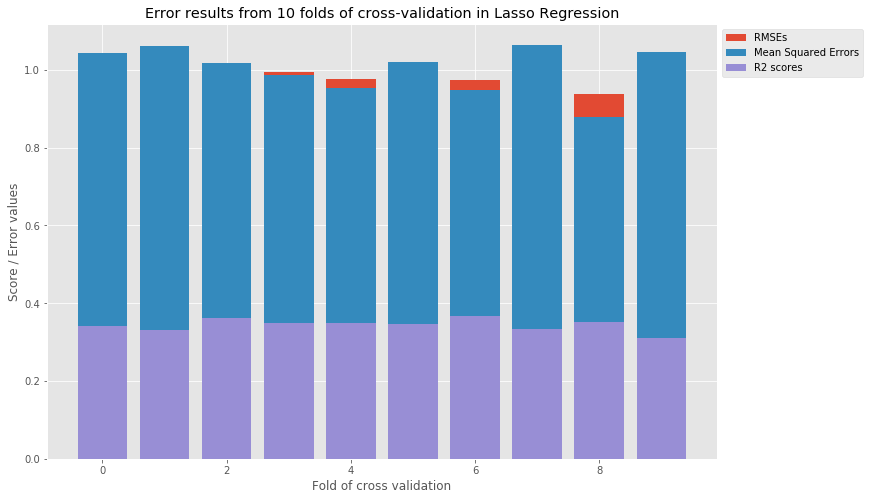

In [100]:
x = list(range(n_folds))
plt.bar(x, [sqrt(i) for i in lasso_MSEs], label="RMSEs")
plt.bar(x, lasso_MSEs, label="Mean Squared Errors")
plt.bar(x, lasso_r2s, label="R2 scores")
plt.legend(bbox_to_anchor=(1,1))
plt.title("Error results from {} folds of cross-validation in Lasso Regression".format(n_folds))
plt.xlabel("Fold of cross validation")
plt.ylabel("Score / Error values")
None

In [101]:
print("Lasso regression score on holdout data: {:.3e}".format(lasso.score(X_hold, y_hold)))

Lasso regression score on holdout data: 3.909e-01


---

### Ridge Regression

In [102]:
ridge_MSEs, ridge_r2s, ridge_coefs, ridge = cross_validate_regression(Ridge, X, y, n_folds, normalize=True, random_state=101)

In [103]:
ridge_mean_MSE = sum(ridge_MSEs)/n_folds
ridge_mean_r2 = sum(ridge_r2s)/n_folds
ridge_rmse = sqrt(ridge_mean_MSE)

In [104]:
print("Ridge Regression results: mean MSE = {:.3e}, mean R2 = {:.3e}, sqrt(mean MSE) = {:.3e}".format(ridge_mean_MSE, 
                                                                                                      ridge_mean_r2, 
                                                                                                      ridge_rmse))

Ridge Regression results: mean MSE = 2.154e-01, mean R2 = 8.586e-01, sqrt(mean MSE) = 4.641e-01


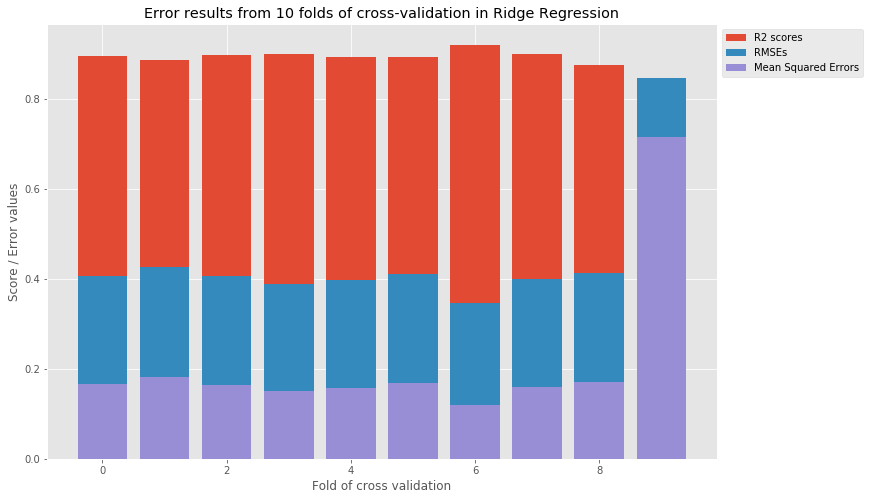

In [105]:
x = list(range(n_folds))
plt.bar(x, ridge_r2s, label="R2 scores")
plt.bar(x, [sqrt(i) for i in ridge_MSEs], label="RMSEs")
plt.bar(x, ridge_MSEs, label="Mean Squared Errors")

plt.legend(bbox_to_anchor=(1,1))
plt.title("Error results from {} folds of cross-validation in Ridge Regression".format(n_folds))
plt.xlabel("Fold of cross validation")
plt.ylabel("Score / Error values")
None

In [106]:
print("Ridge regression score on holdout data: {:.3e}".format(ridge.score(X_hold, y_hold)))

Ridge regression score on holdout data: 9.174e-01
